<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Data and Kaggle Challenge

### Notebook 4/4: Modeling, Selection and Insights

Notebook 1: Preliminary EDA of 'train' dataset .<br>
Notebook 2: Cleaning and Modfications of 'train' and 'test' datasets.<br>
Notebook 3: Preprocessing and Feature Engineering.<br>
Notebook 4: Modeling, Selection and Insights

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Import cleaned dataset
train = pd.read_csv('../datasets/train_final1.csv')

In [3]:
# Import cleaned testset and save IDs separately
test_ids = pd.read_csv('../datasets/test.csv')['Id']
test = pd.read_csv('../datasets/test_final1.csv')

### Model Preparation

#### Train-Test Split + Scaling

Here we are going to standardise our dataset in order to avoid penalising any features due to their scale. 

In [4]:
features = [col for col in train._get_numeric_data().columns if col !='SalePrice']

In [5]:
X = train[features]
y = train['SalePrice']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [8]:
# Instantiate Models 
# Trying out a few different types of regularisation methods as there is still multicollinearity in our dataset

lr = LinearRegression()

In [9]:
ridge = RidgeCV(alphas = np.linspace(1, 200, 100))

In [10]:
lasso = LassoCV(n_alphas = 100)

In [11]:
enet_alphas = np.arange(0.5, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas = enet_alphas, l1_ratio = enet_ratio, cv=5)

### Model Evaluation
#### Cross Validation 
Evaluating the model using `cross_val_score`

In [12]:
# Testing our linear regression model on unseen data
print('Linear Regression')
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)
print('R2:', lr_cv_scores.mean())
lr_cv_mse_scores = -cross_val_score(lr, X_train_scaled, y_train, cv = 5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(lr_cv_mse_scores.mean()))

Linear Regression
R2: 0.8372479172050202
RSME: 31361.358746953887


In [13]:
# Testing our ridge regression model on unseen data
print('Ridge Regession')
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv = 5)
print('R2:', ridge_cv_scores.mean())
ridge_cv_mse_scores = -cross_val_score(ridge, X_train_scaled, y_train, cv = 5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(ridge_cv_mse_scores.mean()))


Ridge Regession
R2: 0.8372421725721996
RSME: 31365.543090746545


In [14]:
# Testing our lasso regression model on unseen data
print('Lasso Regression')
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv = 5)
print('R2:', lasso_cv_scores.mean())
lasso_cv_mse_scores = -cross_val_score(lasso, X_train_scaled, y_train, cv = 5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(lasso_cv_mse_scores.mean()))

Lasso Regression
R2: 0.8361952735248426
RSME: 31450.578564656636


In [15]:
# Testing our elasticnet regression model on unseen data
print('Elasticnet Regression')
enet_cv_scores = cross_val_score(enet, X_train_scaled, y_train, cv = 5)
print('R2:', enet_cv_scores.mean())
enet_cv_mse_scores = -cross_val_score(enet, X_train_scaled, y_train,cv = 5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(enet_cv_mse_scores.mean()))

Elasticnet Regression
R2: 0.8316164395207004
RSME: 31967.162278350293


Comparing all the different types of regularisation, we can see that the normal linear regression model has the worst performance with the highest RMSE score. Based on the above scores, the ridge model has the best performance with an R2 score of 0.863 and an RMSE score of 28708.85 which is marginally better than the rest. 


#### Standard Linear Regression

In [16]:
lr.fit(X_train_scaled,y_train)

print("Training R2(LR): " + str(lr.score(X_train_scaled,y_train)))
print("Testing R2(LR): " + str(lr.score(X_test_scaled,y_test)))
print("Estimate of Testing R2(LR): " + str(lr_cv_scores.mean()))

Training R2(LR): 0.8483654960461193
Testing R2(LR): 0.8300975670702266
Estimate of Testing R2(LR): 0.8372479172050202


In [17]:
print("Training RMSE(LR): " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_scaled)))))
print("Testing RMSE(LR): " + str(np.sqrt(mean_squared_error(y_test,lr.predict(X_test_scaled)))))
print("Estimate of Testing RMSE(LR): " + str(np.sqrt(lr_cv_mse_scores.mean())))

Training RMSE(LR): 30395.905286058914
Testing RMSE(LR): 33753.33869911966
Estimate of Testing RMSE(LR): 31361.358746953887


Based on the above scores, we can see that the model is slightly overfitted as the accuracy between our train and validation data has decreased. 

Next, we will see how the ridge model fares.

#### Ridge Regression

In [18]:
ridge.fit(X_train_scaled, y_train);

In [19]:
# Optimal ridge alpha
best_ridge_alpha = ridge.alpha_
best_ridge_alpha

17.08080808080808

In [20]:
# Create new ridge model with optimal alpha and fit to training data
ridge = Ridge(alpha = best_ridge_alpha)
ridge.fit(X_train_scaled, y_train);

In [21]:
print("Training R2(ridge) " + str(ridge.score(X_train_scaled,y_train)))
print("Testing R2(ridge) " + str(ridge.score(X_test_scaled,y_test)))
print("Estimate of Testing R2(ridge) " + str(ridge_cv_scores.mean()))

Training R2(ridge) 0.8482028735060045
Testing R2(ridge) 0.8298202528335804
Estimate of Testing R2(ridge) 0.8372421725721996


In [22]:
print("Training MSE(Ridge) ", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print("Testing MSE(Ridge) ", np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_scaled))))
print("Estimate of Testing RMSE (Ridge) " + str(np.sqrt(ridge_cv_mse_scores.mean())))

Training MSE(Ridge)  30412.20017473798
Testing MSE(Ridge)  33780.873516757114
Estimate of Testing RMSE (Ridge) 31365.543090746545


The ridge model seems to be overfitted as well, but is seen to produce slightly better results that the standard linear model regression.

#### Lasso Regression

In [23]:
# Fit LassoCV model to data
lasso.fit(X_train_scaled, y_train)

LassoCV()

In [24]:
# Generate best alpha
best_lasso_alpha = lasso.alpha_
best_lasso_alpha

62.304838037721716

In [25]:
# Create new lasso model with optimal alpha and fit to training data
lasso = Lasso(alpha = best_lasso_alpha)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=62.304838037721716)

In [26]:
print("Training R2(Lasso) ", lasso.score(X_train_scaled, y_train))
print("Testing R2(Lasso):", lasso.score(X_test_scaled, y_test))
print("Estimate of Testing R2(Lasso):", lasso_cv_scores.mean())

Training R2(Lasso)  0.8482079066043153
Testing R2(Lasso): 0.8302271954350436
Estimate of Testing R2(Lasso): 0.8361952735248426


In [27]:
print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_scaled))))
print("Estimate of Testing RMSE(Lasso):", np.sqrt(lasso_cv_mse_scores.mean()))

Training RMSE(Lasso): 30411.695985806044
Testing RMSE(Lasso): 33740.46005781624
Estimate of Testing RMSE(Lasso): 31450.578564656636


The lasso model is also overfitted but as with the ridge model, it produces better results than the standard linear regression model. Comparing the lasso and ridge model, the ridge model seems to have a slightly better performance. 

#### ElasticNet Regression

In [28]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas = enet_alphas, l1_ratio = enet_ratio, cv = 5, max_iter = 5000)
enet = enet.fit(X_train_scaled, y_train)

In [29]:
# Optimal Enet Alpha
enet_optimal_alpha = enet.alpha_
enet_optimal_alpha

0.015

In [30]:
# Create new enet model with optimal alpha and fit to training data
enet = ElasticNet(alpha = enet_optimal_alpha)
enet.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.015)

In [31]:
enet_cv_scores = cross_val_score(enet,X_train_scaled,y_train,cv=5)
enet_cv_scores.mean()

0.83730210716651

In [32]:
enet_cv_mse_scores = -cross_val_score(enet,X_train_scaled,y_train,cv=5, scoring ='neg_mean_squared_error')
np.sqrt(enet_cv_mse_scores.mean())

31356.742604851428

In [33]:
print('Training R2(ElasticNet):', enet.score(X_train_scaled, y_train))
print('Testing R2(ElasticNet):', enet.score(X_test_scaled, y_test))
print('Estimate of Testing R2(ElasticNet): ', enet_cv_scores.mean())

Training R2(ElasticNet): 0.8482877643027793
Testing R2(ElasticNet): 0.8299478892304396
Estimate of Testing R2(ElasticNet):  0.83730210716651


In [34]:
print('Training MSE(ElasticNet):', np.sqrt(mean_squared_error(y_train, enet.predict(X_train_scaled))))
print('Testing MSE(ElasticNet):', np.sqrt(mean_squared_error(y_test, enet.predict(X_test_scaled))))
print('Estimate of Testing RMSE(ElasticNet):', np.sqrt(enet_cv_mse_scores.mean()))

Training MSE(ElasticNet): 30403.69514893861
Testing MSE(ElasticNet): 33768.20315556097
Estimate of Testing RMSE(ElasticNet): 31356.742604851428


The ElasticNet model is also overfitted and fares slightly better than the standard linear regression model but is worse off when compared to the ridge and lasso model. 

### Submission

In [35]:
# Refit model on entire training dataset
X_scaled = ss.fit_transform(X)
lasso = LassoCV()
lasso.fit(X_scaled, y)
lasso.score(X_scaled,y)

0.8437686125996595

In [36]:
# Remaining features after zeroing by lasso regression
print('Total Features before Lasso regression:', len(features))
print('Features Zeroed by Lasso regression:', len(lasso.coef_[lasso.coef_ == 0]))
print('Features Remaining after Lasso regression:', len(features) - len(lasso.coef_[lasso.coef_ == 0]))


Total Features before Lasso regression: 30
Features Zeroed by Lasso regression: 0
Features Remaining after Lasso regression: 30


In [37]:
final_test_scaled = ss.transform(test)

In [38]:
final_predictions = lasso.predict(final_test_scaled)

In [39]:
test['SalePrice'] = final_predictions

In [40]:
test['Id'] = test_ids

In [41]:
# Create csv for submission
submission = test[['Id','SalePrice']]
submission.to_csv('../datasets/kaggle_submission.csv', index=False)

#View submission
submission.head()

,Id,SalePrice
0,2658,124382.050021
1,2718,128272.269709
2,2414,245064.419899
3,1989,115925.341876
4,625,189128.707055


In [42]:
submission.shape

(878, 2)

In [43]:
# Refit model on entire training dataset
X_scaled = ss.fit_transform(X)
ridge = RidgeCV()
ridge.fit(X_scaled, y)
ridge.score(X_scaled,y)

0.843903399148797

In [44]:
# Remaining features after zeroing by lasso regression
print('Total Features before Ridge regression:', len(features))
print('Features Zeroed by Ridge regression:', len(ridge.coef_[ridge.coef_ == 0]))
print('Features Remaining after Ridge regression:', len(features) - len(ridge.coef_[ridge.coef_ == 0]))

Total Features before Ridge regression: 30
Features Zeroed by Ridge regression: 0
Features Remaining after Ridge regression: 30


In [45]:
final_predictions_ridge = ridge.predict(final_test_scaled)

In [46]:
test['SalePrice'] = final_predictions_ridge
test['Id'] = test_ids

# Create csv for submission
submission_ridge = test[['Id','SalePrice']]
submission_ridge.to_csv('../datasets/kaggle_submission_ridge.csv', index=False)

#View submission
submission_ridge.head()

,Id,SalePrice
0,2658,124319.380600
1,2718,128279.243210
2,2414,245063.426443
3,1989,116157.780901
4,625,189186.489783


In [47]:
submission_ridge.shape

(878, 2)

In [48]:
# Refit model on entire training dataset
X_scaled = ss.fit_transform(X)
enet = ElasticNetCV()
enet.fit(X_scaled, y)
enet.score(X_scaled,y)

0.0916777324980379

In [49]:
# Remaining features after zeroing by lasso regression
print('Total Features before ElasticNet regression:', len(features))
print('Features Zeroed by ElasticNet regression:', len(enet.coef_[enet.coef_ == 0]))
print('Features Remaining after ElasticNet regression:', len(features) - len(enet.coef_[enet.coef_ == 0]))


Total Features before ElasticNet regression: 30
Features Zeroed by ElasticNet regression: 0
Features Remaining after ElasticNet regression: 30


In [50]:
final_predictions_enet = enet.predict(final_test_scaled)

In [51]:
test['SalePrice'] = final_predictions_enet
test['Id'] = test_ids

# Create csv for submission
submission_enet = test[['Id','SalePrice']]
submission_enet.to_csv('../datasets/kaggle_submission_enet.csv', index=False)

#View submission
submission_enet.head()

,Id,SalePrice
0,2658,176568.767971
1,2718,178552.423966
2,2414,186258.934348
3,1989,177284.112589
4,625,181124.389188


In [52]:
submission_enet.shape

(878, 2)

The Lasso model produced a better score on Kaggle and will be the one used. 

In [53]:
train['SalePrice'].mean()

181479.01805758907

### Conclusion

Based on the scores returned from Kaggle, the Lasso model was the most successful in predicting housing sale prices. On the dataset comprising of 30% of the test data, the model achieved an RMSE of 33859.87. On the dataset comprising of the other 70% of the test data, the model performed within expectations, returning an RMSE of 25979.44. This is a strong improvement over the baseline score (~181,000) generated by using the mean of all sale prices as predictions. This answers our problem statement of how we can best predict housing prices.

Earlier versions of the model without systematic feature engineering saw up to a difference of 9,000 in terms of RMSE when given the two different test datasets. Overall, the model seems to have become much more generalizable and consistent. It also has a high R2 on our training data, where it can explain up to 88.4% of the variance in sale price.

Text(0.5, 1.0, 'Ridge Predictions of Sale Price vs Actual Sale Price')

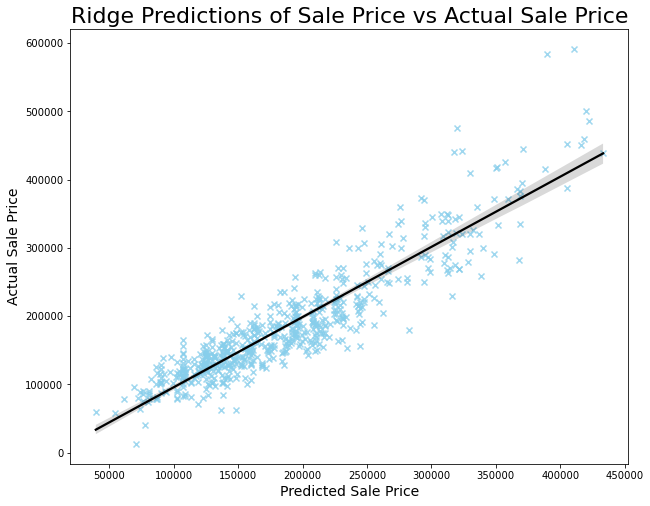

In [54]:
# Create scatterplot to show predicted values versus actual values
ridge_preds = ridge.predict(X_test_scaled)

plt.figure(figsize = (10,8))
sns.regplot(data = X_train_scaled, x = ridge_preds, y = y_test, marker = 'x', color = 'skyblue', line_kws = {'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize = 14)
plt.ylabel('Actual Sale Price', fontsize = 14)
plt.title('Ridge Predictions of Sale Price vs Actual Sale Price', fontsize = 22)

From the graph above, we can see that the line of best fit passes through most of the points aside from a few outliers in the higher end of the sale price range. We cna then say that the model is acceptable. 

Text(0.5, 1.0, 'Residuals')

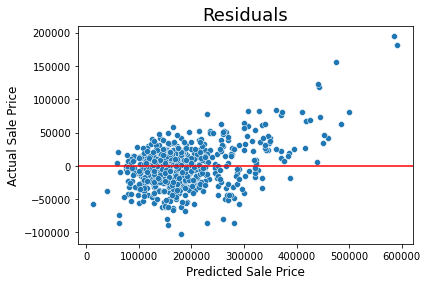

In [55]:
ax = sns.scatterplot(data = train, x = y_test, y = y_test - ridge_preds)
ax.axhline(y = 0, c = 'red')
plt.xlabel('Predicted Sale Price', fontsize = 12)
plt.ylabel('Actual Sale Price', fontsize = 12)
plt.title('Residuals', fontsize = 18)

We can see from the above that the residuals are generally equally distributed. This supports the multiple linear regression assumption of homoscedasticity which states that the variance of error must be similar across the values of the independent variables. 

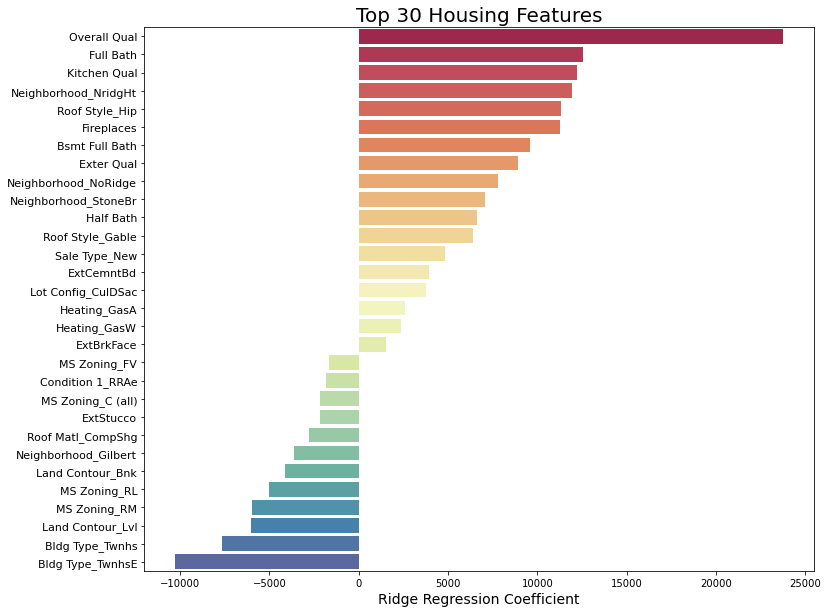

In [56]:
# Create dataframe of features, coefficients and absolute coefficients
ridge_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
ridge_df['Abs Coef'] = abs(ridge.coef_)
ridge_df['Coef'] = ridge.coef_
ridge_df['Feature'] = features

# Plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize=(12,10))
data = ridge_df.sort_values(by = 'Abs Coef', ascending = False).head(30)[['Feature', 'Coef']] \
               .sort_values(by = 'Coef', ascending = False).reset_index(drop = True)
    
ax = sns.barplot(data = data, y ='Feature', x = 'Coef', orient = 'h', palette = 'Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size = 11)
ax.set_xlabel('Ridge Regression Coefficient', fontsize = 14)
plt.title('Top 30 Housing Features', fontsize = 20);

In [57]:
# Displaying top 20 coefficients - Top 15 positive coefficients and bottom 5 negative coefficients
display(data.head(15), data.tail(5))

,Feature,Coef
0,Overall Qual,23775.043715
1,Full Bath,12563.612005
2,Kitchen Qual,12206.696851
3,Neighborhood_NridgHt,11954.249407
4,Roof Style_Hip,11342.340239
5,Fireplaces,11259.833002
6,Bsmt Full Bath,9584.240155
7,Exter Qual,8913.507064
8,Neighborhood_NoRidge,7815.913290
9,Neighborhood_StoneBr,7060.294195


,Feature,Coef
25,MS Zoning_RL,-5012.558430
26,MS Zoning_RM,-5972.758256
27,Land Contour_Lvl,-6046.817958
28,Bldg Type_Twnhs,-7642.758891
29,Bldg Type_TwnhsE,-10311.102700


Overall, the top predictive features seems reasonable with our top two features being the overall quality and the total of rooms above grade. This is followed by other features looking at the quality of the kitchen and basement as well as full bathrooms. Certain neighbourhoods such as Northridge Heights, Stone Brook and Northridge were also found to be strong positive predictors. 

Conversely, we see that houses that are in `MS SubClass_120` (1 story houses built in 1946 and after, as part of a planned unit development) predict lower prices. The Gilbert neighborhood also predicts lower prices, along with certain features such as the hard board exterior covering on the house. Having two stories also hurts the value of the home as well as having a split level style of dwelling. 

#### Feature coefficients

In [58]:
ridge.intercept_

181479.01805758907

Linear regression equation where the feature coefficients can be interpreted as β1:

$$   y =  \beta_0 +  \beta_1 x_1 + \epsilon $$

The predicted value of Y here is affected by β1 which represents the estimated slope. For every 1 unit change in `Overall Qual` (X1), the target variable (y), `SalePrice`, will increase by $15,547. This number has a pretty large magnitude which makes it easy for the model to become overfit as a slight increase in `Overall Qual` will result in a large shift as compared to changes to other features.    

The intercept of our model (β0) is \\$181,479 which suggests that when our predictors are equal to 0, the mean sale price is $181,479. However, this is not as relevant as our X will never be 0.

In short, we can interpet our `Overall Qual` coefficient's effect on our model as:

$$   Sale\hat Price = 181479 + 15547[Overall Qual]    $$


### Recommendations

Based on the model, there are several ways to increase the value of a house in Ames (for sellers):
- Renovate to improve the overall, basement and exterior quality of the house
- Improve grade of the bathrooms
- Increase the number of Fireplaces
- Increase the garage size to fit more than one car
- If using a hard board exterior, switch to cement or brick instead

Based on the model, there are several ways to efficiently look for a lower value house in Ames (for buyers):
- Avoid neighbourhood such as Northridge Heights, Stone Brook and Northridge.
- Instead go for neighbourhood such as Gilbert. 
- Look for 1 story houses built in 1946 and after, as part of a planned unit development
- Houses with a split level style of dwelling

### Model Limitations

While this model generalizes well to the city of Ames, it's probably not generalizable to other cities, given that each city tends to differ greatly in terms of external factors like geographical features, seasonal weather or the economic climate of that particular city.


#### Tradeoffs between interpretability and accuracy
A key consideration in this project was whether to create a more interpretable model which had a total of 30 or less features. Ultimately, I decided against this as this led to a significant tradeoff in accuracy. Using RFE to select more than 30 features greatly reduced my model's R2 and RMSE -- I believe that in this case it's not worth trading off model complexity for accuracy, given the model's current performance with less than 100 features.

This however does create some limitations. For one, some of the negative predictors are hard to interpret without extensive domain knowledge. For example, on the surface, it doesn't seen logical for the number of kitchens or bedrooms to be negative predictors for price. This can be explained by the fact that these features are acting as a proxy for other features.

For Kitchen AbvGr, I realized that houses with two kitchens have a lower mean sale price and were older compared to houses with one kitchen. In Iowa, summer kitchens were used prior to electricity and air conditioning to keep the heat from cooking out of the house during hot summer months. In colder months, the indoor kitchens was used to help keep the house warm. The fact that houses with two kitchens generally don't have much porch square footage supports this idea (as summer kitchens are generally located on the back porch). This suggests that houses with two kitchens are more likely to be antiquated houses without a good heating/ventilation system.